# Web Anomaly Detection

## Load data and library

In [16]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import boto3
from sagemaker import get_execution_role
import pandas_profiling
import warnings
warnings.filterwarnings('ignore')

In [27]:
role = get_execution_role()
bucket='vincentwan'
train_data_key = 'Train_data.csv'
test_data_key = 'Test_data.csv'
train_data_location = 's3://{}/{}'.format(bucket, train_data_key)
test_data_location = 's3://{}/{}'.format(bucket, test_data_key)
train = pd.read_csv(train_data_location)
test = pd.read_csv(test_data_location)

In [28]:
print("Training data has {} rows & {} columns".format(train.shape[0],train.shape[1]))

Training data has 25192 rows & 42 columns


In [29]:
print("Testing data has {} rows & {} columns".format(test.shape[0],test.shape[1]))

Testing data has 22544 rows & 41 columns


### Get the profile of the train dataset

In [30]:
pandas_profiling.ProfileReport(train)

Number of variables,42
Number of observations,25192
Total Missing (%),0.0%
Total size in memory,8.1 MiB
Average record size in memory,336.0 B
Numeric,23
Categorical,4
Boolean,6
Date,0
Text (Unique),0
Rejected,9


In [31]:
profile = pandas_profiling.ProfileReport(train)
rejected_variables = profile.get_rejected_variables(threshold=0.9)

In [32]:
print(rejected_variables)

['dst_host_rerror_rate', 'dst_host_serror_rate', 'dst_host_srv_rerror_rate', 'dst_host_srv_serror_rate', 'num_root', 'srv_rerror_rate', 'srv_serror_rate']


### drop the columns have high correlation and constant value

In [33]:
train.drop(rejected_variables, axis=1, inplace=True)
test.drop(rejected_variables, axis=1, inplace=True)
train.drop(['is_host_login'], axis=1, inplace=True)
test.drop(['is_host_login'], axis=1, inplace=True)
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [34]:
print("Training data has {} rows & {} columns".format(train.shape[0],train.shape[1]))
print("Testing data has {} rows & {} columns".format(test.shape[0],test.shape[1]))

Training data has 25192 rows & 33 columns
Testing data has 22544 rows & 32 columns


### Check the balance of the dataset

In [35]:
train['class'].value_counts()

normal     13449
anomaly    11743
Name: class, dtype: int64

## SCALING NUMERICAL ATTRIBUTES

In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(test.select_dtypes(include=['float64','int64']))

# turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

## ENCODING CATEGORICAL ATTRIBUTES

In [39]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# extract categorical attributes from both training and test sets 
cattrain = train.select_dtypes(include=['object']).copy()
cattest = test.select_dtypes(include=['object']).copy()

# encode the categorical attributes
traincat = cattrain.apply(encoder.fit_transform)
testcat = cattest.apply(encoder.fit_transform)

# separate target column from encoded data 
enctrain = traincat.drop(['class'], axis=1)
cat_Ytrain = traincat[['class']].copy()

In [40]:
train_x = pd.concat([sc_traindf,enctrain],axis=1)
train_y = train['class']
train_x.shape

(25192, 32)

In [41]:
test_df = pd.concat([sc_testdf,testcat],axis=1)
test_df.shape

(22544, 32)

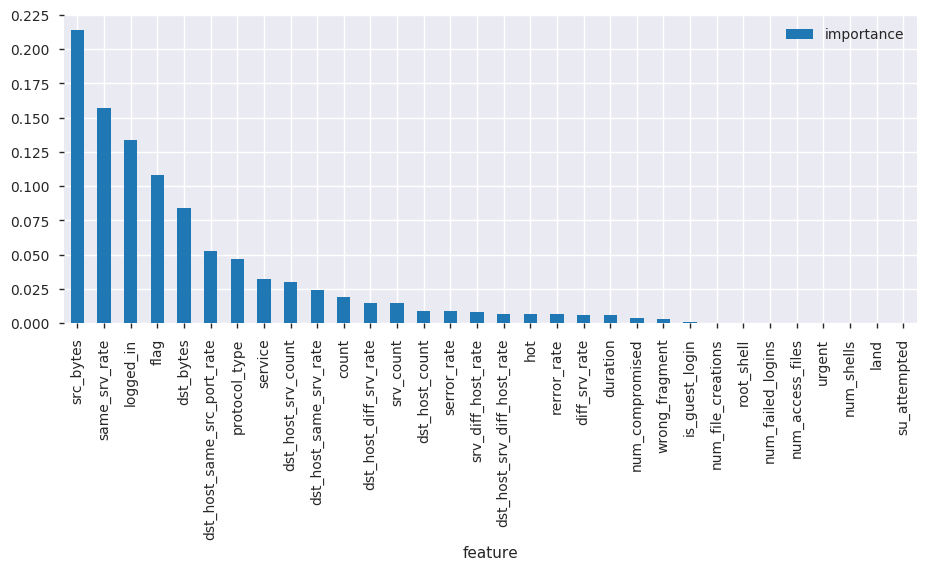

In [42]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

# fit random forest classifier on the training set
rfc.fit(train_x, train_y);
# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':train_x.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [45]:
from sklearn.feature_selection import RFE
import itertools
rfc = RandomForestClassifier()

# create the RFE model and select 10 attributes
rfe = RFE(rfc, n_features_to_select=15)
rfe = rfe.fit(train_x, train_y)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.izip_longest(rfe.get_support(), train_x.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['src_bytes',
 'dst_bytes',
 'hot',
 'count',
 'srv_count',
 'serror_rate',
 'diff_srv_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'protocol_type',
 'service',
 'flag']

In [46]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(train_x,train_y,train_size=0.70, random_state=2)

In [50]:
from sklearn.svm import SVC 
from sklearn.naive_bayes import BernoulliNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Train KNeighborsClassifier Model
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier.fit(X_train, Y_train); 

# Train LogisticRegression Model
LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0)
LGR_Classifier.fit(X_train, Y_train);

# Train Gaussian Naive Baye Model
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train, Y_train)
            
# Train Decision Tree Model
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier.fit(X_train, Y_train)

#Train RCF model
RCF_Classifier = RandomForestClassifier();
RCF_Classifier.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [51]:
from sklearn import metrics

models = []
models.append(('Naive Baye Classifier', BNB_Classifier))
models.append(('Decision Tree Classifier', DTC_Classifier))
models.append(('KNeighborsClassifier', KNN_Classifier))
models.append(('LogisticRegression', LGR_Classifier))
models.append(('RandomForest Classifier', RCF_Classifier))
for i, v in models:
    scores = cross_val_score(v, X_train, Y_train, cv=10)
    accuracy = metrics.accuracy_score(Y_train, v.predict(X_train))
    confusion_matrix = metrics.confusion_matrix(Y_train, v.predict(X_train))
    classification = metrics.classification_report(Y_train, v.predict(X_train))
    print()
    print('============================== {} Model Evaluation =============================='.format(i))
    print()
    print ("Cross Validation Mean Score:" "\n", scores.mean())
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()

()
============================== Naive Baye Classifier Model Evaluation ==============================
()
('Cross Validation Mean Score:\n', 0.8910622091071689)
()
('Model Accuracy:\n', 0.8909493024838381)
()
('Confusion matrix:\n', array([[7042, 1203],
       [ 720, 8669]]))
()
('Classification report:\n', u'             precision    recall  f1-score   support\n\n    anomaly       0.91      0.85      0.88      8245\n     normal       0.88      0.92      0.90      9389\n\navg / total       0.89      0.89      0.89     17634\n')
()
()
============================== Decision Tree Classifier Model Evaluation ==============================
()
('Cross Validation Mean Score:\n', 0.9954630837153114)
()
('Model Accuracy:\n', 1.0)
()
('Confusion matrix:\n', array([[8245,    0],
       [   0, 9389]]))
()
('Classification report:\n', u'             precision    recall  f1-score   support\n\n    anomaly       1.00      1.00      1.00      8245\n     normal       1.00      1.00      1.00      9389